In [32]:
import os
import gc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

import cv2
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device".format(device))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
#print('Count of using GPUs:', torch.cuda.device_count())

using cpu device
Device: cpu


In [33]:
categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
dir_c = './train_img_aug(150)/cafe_aug/'
dir_r = './train_img_aug(150)/restaurant_aug/'

def load_img(dir): 

    X = []
    Y = []

    for index , category in enumerate(categories):
        label = index + 1
        img_dir = dir + category +'/'

        for top, directory , f  in os.walk(img_dir):
            for filename in f:
                img = cv2.imread(img_dir + filename , cv2.IMREAD_COLOR)
                img = cv2.resize(img,(200,200), cv2.INTER_AREA)
                X.append(img)
                Y.append(label)

    return X , Y

In [34]:
img_c ,label_c = load_img(dir_c)
img_r ,label_r = load_img(dir_r)

In [35]:
img_c = np.array(img_c)
label_c = np.array(label_c)
img_r = np.array(img_r)
label_r = np.array(label_r)

In [36]:
label_r += 10

In [37]:
X = np.vstack([img_c,img_r])
Y = np.hstack([label_c,label_r])

In [38]:
X = np.array(X, dtype="float32") / 255.0

In [39]:
le = LabelBinarizer()
Y = le.fit_transform(Y)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size = 0.20 ,stratify=Y, random_state=42) # 학습 / 테스트 스플릿
X_train , X_val , Y_train , Y_val = train_test_split(X_train,Y_train , test_size = 0.20 , stratify = Y_train , random_state = 42)

In [10]:
print(X_train.shape)
print(X_val.shape)

(1920, 200, 200, 3)
(480, 200, 200, 3)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

In [72]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5),
                activation = 'elu',
                padding = 'same',
                input_shape = (200, 200, 3)))
model.add(MaxPooling2D(pool_size = (2,2),
                      strides = (2,2)))
model.add(Conv2D(64, kernel_size = (5,5),
                activation = 'elu',
                padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size = (5,5),
                activation = 'elu',
                padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size = (5,5),
                activation = 'elu',
                padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(20, activation = 'softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 200, 200, 32)      2432      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 64)      51264     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 64)        102464    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 64)      

In [73]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'Adam', metrics = ['accuracy'])

In [74]:
hist = model.fit(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), batch_size = 32)

Epoch 1/10
60/60 [==============================] - 70s 1s/step - loss: 3.0341 - accuracy: 0.0474 - val_loss: 3.0059 - val_accuracy: 0.0500
Epoch 2/10
60/60 [==============================] - 70s 1s/step - loss: 3.0156 - accuracy: 0.0453 - val_loss: 3.0056 - val_accuracy: 0.0500
Epoch 3/10
60/60 [==============================] - 72s 1s/step - loss: 3.0079 - accuracy: 0.0526 - val_loss: 2.9946 - val_accuracy: 0.0479
Epoch 4/10
60/60 [==============================] - 70s 1s/step - loss: 2.9957 - accuracy: 0.0562 - val_loss: 2.9762 - val_accuracy: 0.0917
Epoch 5/10
60/60 [==============================] - 70s 1s/step - loss: 2.9623 - accuracy: 0.0661 - val_loss: 2.9469 - val_accuracy: 0.0812
Epoch 6/10
60/60 [==============================] - 69s 1s/step - loss: 2.9343 - accuracy: 0.1005 - val_loss: 2.9162 - val_accuracy: 0.0875
Epoch 7/10
60/60 [==============================] - 69s 1s/step - loss: 2.9062 - accuracy: 0.1000 - val_loss: 2.8851 - val_accuracy: 0.1104
Epoch 8/10
60/60 [==

In [75]:
y_hat = model.predict(X_test)

19/19 [==============================] - 4s 208ms/step


In [76]:
target = []
for i in range(len(y_hat)):
    target.append(np.argmax(y_hat[i]))

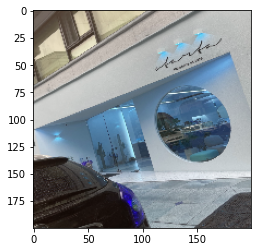

In [77]:
plt.imshow(X_test[0])

In [78]:
target[0]

5

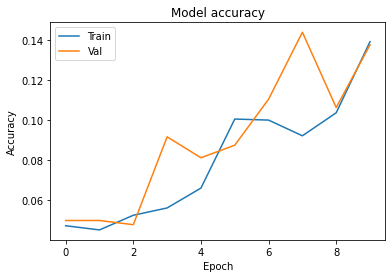

In [79]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()